In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
filenames = [
    #'ks3458a-sr104-log.csv',
    'ks3458a-k2000-sr104-log.csv',
    'ks3458a-k2000-transfer-sr104-log.csv',
]
axis1_columns=['ag3458a_2_ohm']
axis2_columns=['k2000_temp_ohm']

In [4]:
days = mdates.DayLocator()
days7 = mdates.DayLocator(interval=7)
months = mdates.MonthLocator()
years = mdates.YearLocator()
daysFmt = mdates.DateFormatter('%Y-%m')
monthsFmt = mdates.DateFormatter('%Y-%m')
yearsFmt = mdates.DateFormatter('%Y')

In [6]:
thp2 = pd.read_csv('thp_log.csv', parse_dates=['datetime'])
thp2_Pa = thp2.loc[thp2['pressure'] > 10000, 'pressure']
thp2.loc[thp2['pressure'] > 10000, 'pressure'] = thp2_Pa / 100
thp2_sorted = thp2.set_index('datetime').sort_values('datetime')

In [7]:
def add_thp(data):
    return pd.merge_asof(data.set_index('datetime'), thp2_sorted, left_index=True, right_index=True, direction='nearest')

data_dict = {filename: add_thp(pd.read_csv(filename, parse_dates=['datetime'])) for filename in filenames}

In [8]:
data = pd.concat(data_dict.values(), sort=True)

In [9]:
def filter_column_on_percentile(series):
    p_low = np.percentile(series, 5)
    p_high = np.percentile(series, 95)
    return series[(series > p_low) & (series < p_high)]

def ppm_for_column(series):
    mean = series.mean()
    return (series - mean) / mean * 1e6

def plot_volt(volt_data, ax):
    lns = []
    for column_name in axis1_columns:
        column = filter_column_on_percentile(volt_data[column_name].dropna())
        ppm = ppm_for_column(column)
        lns.append(ax.plot(ppm.index, ppm, ',', label=column_name)[0])
    par1 = ax.twinx()
    for column_name in axis2_columns:
        column = filter_column_on_percentile(volt_data[column_name].dropna())
        ppm = ppm_for_column(column)
        lns.append(par1.plot(ppm.index, ppm, ',', label=column_name)[0])
    ax.set_xlabel("Time")
    ax.set_ylabel("ppm")
    par1.set_ylabel("ppm")
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.legend(handles=lns, numpoints=10, loc='best')

In [10]:
def plot_thp(thp_data, ax):

    par1 = ax.twinx()
    par2 = ax.twinx()

    ax.set_xlabel("Time")
    ax.set_ylabel("Temperature (°C)")
    par1.set_ylabel("Humidity (%)")
    par2.set_ylabel("Pressure (Pa)")

    color1 = plt.cm.viridis(0)
    color2 = plt.cm.viridis(0.5)
    color3 = plt.cm.viridis(0.8)

    #dates = list(map(mdates.date2num, get_column_from_dictlist(thp_values, 'datetime')))
    p1, = ax.plot(thp_data.index, thp_data['temperature'], ',', color=color1, label="Temperature")
    p2, = par1.plot(thp_data.index, thp_data['humidity'], ',', color=color2, label="Humidity")
    p3, = par2.plot(thp_data.index, thp_data['pressure'], ',', color=color3, label="Pressure")

    lns = [p1, p2, p3]
    ax.legend(handles=lns, numpoints=10, loc='best')

    # right, left, top, bottom
    par2.spines['right'].set_position(('outward', 60))
    # no x-ticks                 
    #par2.xaxis.set_ticks([])
    # Sometimes handy, same for xaxis
    #par2.yaxis.set_ticks_position('right')

    ax.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())

In [11]:
def plot():
    fig = plt.figure()
    ax_volt = plt.subplot2grid((2,2), (0,0))
    ax_thp = plt.subplot2grid((2,2), (1,0), sharex=ax_volt)
    ax_tc = plt.subplot2grid((2,2), (0, 1), rowspan=2)
    fig.subplots_adjust(hspace=0, wspace=0.4, left=0.05, right=0.95, top=0.95,
            bottom=0.05)
    fig.subplots_adjust(wspace=0.35)
    plot_volt(data, ax_volt)
    thp2_during_data = thp2_sorted[(thp2_sorted.index >= data.index.min()) & (thp2_sorted.index <= data.index.max())]
    plot_thp(thp2_during_data, ax_thp)

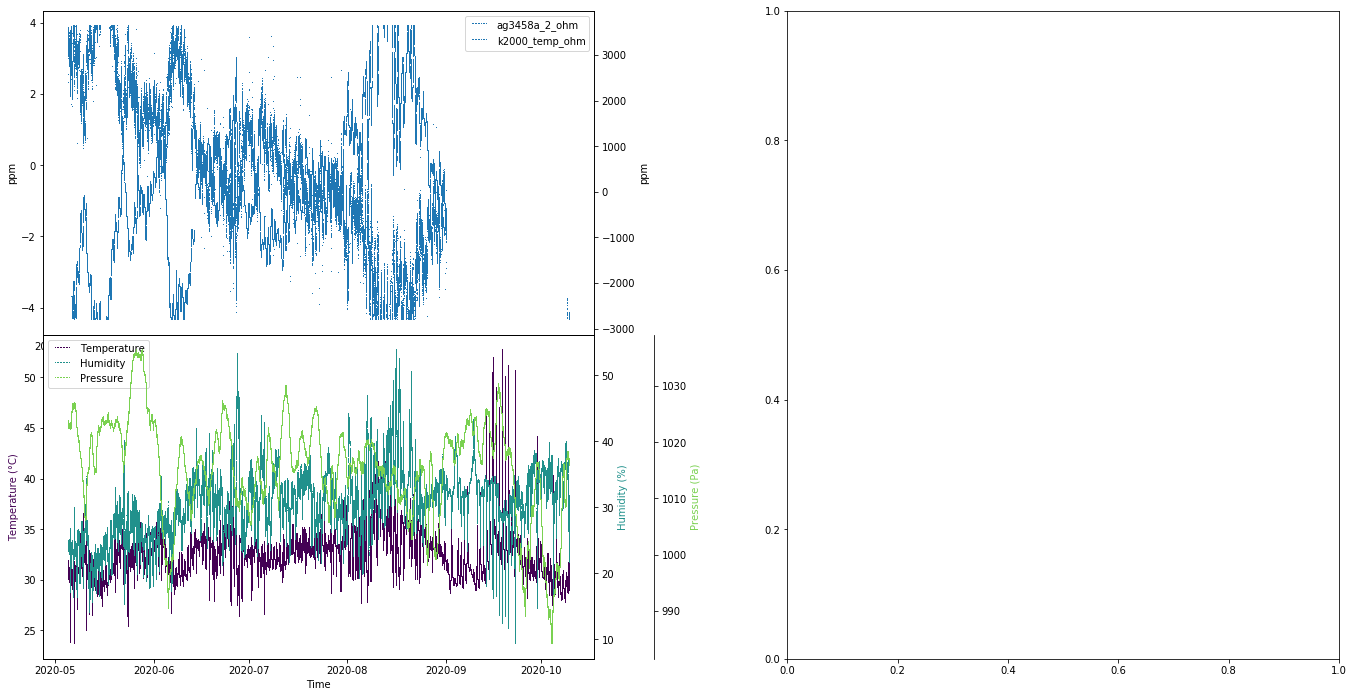

In [23]:
plot()

In [12]:
data_dict = {filename: pd.read_csv(filename, parse_dates=['datetime', 'last_acal_2']) for filename in filenames}
data = pd.concat(data_dict.values(), sort=True)

In [13]:
# From SR104 data
Rth = lambda T: (0.1e-2*10e3)*(T-23) + ((1+0.003e-2)*10e3)
Trh = lambda Rt: (Rt - ((1+0.003e-2)*10e3)) / (0.1e-2*10e3) + 23
Rs23 = 10e3*(1-1.4e-6)
Rt  = lambda T: Rs23 * (1 - 0.04e-6 * (T-23) - 0.025e-6 * (T-23)**2)

In [14]:
data = data[data['k2000_temp_ohm'] > 9900]
data = data.reset_index().drop('index', axis=1)
data['last_acal_2_diff'] = data['last_acal_2'].diff()
data['temp_sr104'] = Trh(data['k2000_temp_ohm'])
data['sr104_corrected'] = Rt(data['temp_sr104'])
data['ag3458a_2_ohm_deviation'] = data['ag3458a_2_ohm'] - data['sr104_corrected']
data['ag3458a_2_ohm_deviation_ppm'] = (data['ag3458a_2_ohm'] - data['sr104_corrected']) / data['sr104_corrected'] * 1e6

In [15]:
idx=data.index[data['last_acal_2'].diff() != pd.Timedelta(0)]
acal_data = pd.concat([data.iloc[x : min(y, data.index.max()+1)] for x , y in zip(idx, idx+10)])

In [40]:
agg_acal_data = acal_data.groupby('last_acal_2').agg({'ag3458a_2_ohm_deviation_ppm': ['mean', 'std', 'sem'], 'k2000_temp_ohm': ['mean', 'std', 'sem'], 'temp_2': 'first', 'datetime': 'first'})
agg_acal_data_wo_na = agg_acal_data[agg_acal_data.index > pd.Timestamp(2022,1,1)].dropna()
#agg_acal_data = agg_acal_data[~agg_acal_data['k2000_temp_ohm']['mean'].isnull()]

In [41]:
lm = LinearRegression()
lm.fit(agg_acal_data_wo_na['temp_2']['first'].to_numpy().reshape(-1, 1), agg_acal_data_wo_na['ag3458a_2_ohm_deviation_ppm']['mean'].to_numpy())

LinearRegression()

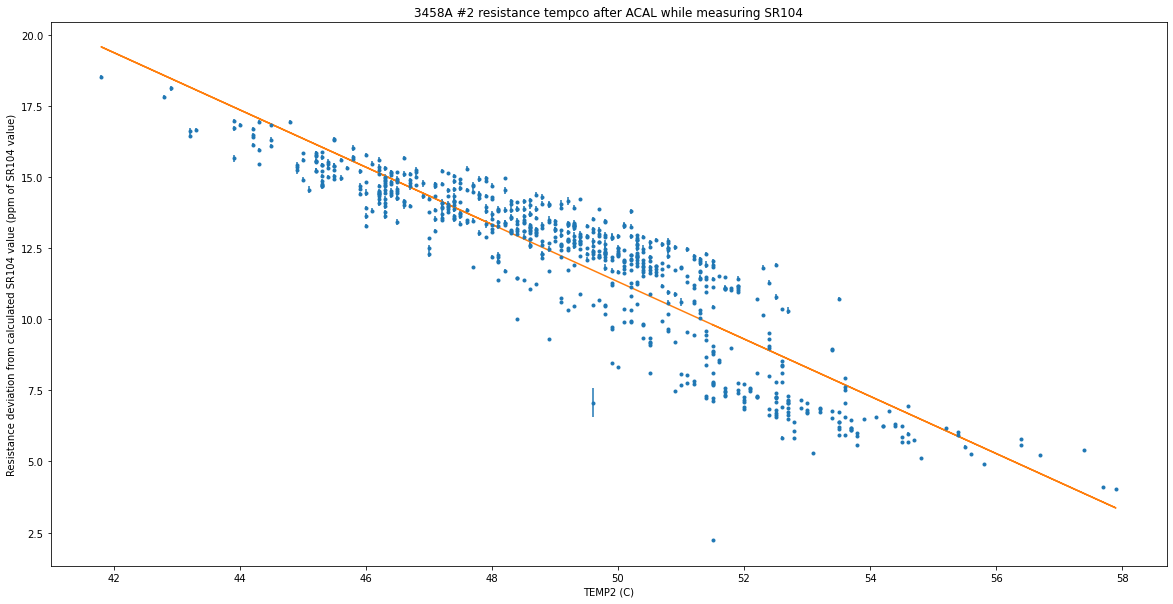

In [42]:
f = plt.figure()
plt.errorbar(x=agg_acal_data_wo_na['temp_2']['first'], y=agg_acal_data_wo_na['ag3458a_2_ohm_deviation_ppm']['mean'], yerr=agg_acal_data_wo_na['ag3458a_2_ohm_deviation_ppm']['sem'], fmt='.')
plt.plot(agg_acal_data_wo_na['temp_2']['first'], lm.predict(agg_acal_data_wo_na['temp_2']['first'].dropna().to_numpy().reshape(-1, 1)))
plt.xlabel('TEMP2 (C)')
plt.ylabel('Resistance deviation from calculated SR104 value (ppm of SR104 value)')
plt.title('3458A #2 resistance tempco after ACAL while measuring SR104')
plt.show()
f.savefig("ag3458a2 SR104 R207 tempco.png", bbox_inches='tight', dpi=100)

In [43]:
lm.coef_

array([-1.00663189])

In [38]:
r2_score(agg_acal_data_wo_na['ag3458a_2_ohm_deviation_ppm']['mean'], lm.predict(agg_acal_data_wo_na['temp_2']['first'].to_numpy().reshape(-1, 1)))

0.4827724702027332